U-net
======

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from matplotlib import pyplot as plt

Parameter Settings
-------------------


In [2]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
use_gpu = True
image_size = 256


Data Loading
-------------------

We do not center images at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps

#from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

class CustomDataSet(Dataset):
    def __init__(self, input_dir=f'./five_cropped_input{image_size}',
                       output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        if black_and_white:
            self.input_dir += '(bw)'
            self.output_dir += '(bw)'
        self.transform = transform
        self.total_imgs = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc_in = os.path.join(self.input_dir, self.total_imgs[idx])
        img_loc_out = os.path.join(self.output_dir, self.total_imgs[idx])
        fig_in = ImageOps.invert(Image.open(img_loc_in))
        fig_out = ImageOps.invert(Image.open(img_loc_out))
        tensor_image_in = self.transform(fig_in)
        tensor_image_out = self.transform(fig_out)

        # внимание: задача инверсной фотолитографии - меняем вход и выход!
        
        #return tensor_image_in, tensor_image_out
        return tensor_image_out, tensor_image_in
        

full_dataset = CustomDataSet(input_dir=f'./five_cropped_input{image_size}',
                             output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=img_transform)

train_size = 15000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(15000, 7030, 118, 55)

In [5]:
train_dataset[0][0].shape

torch.Size([1, 256, 256])

In [6]:
for batch, _ in train_dataloader:
    print(batch.shape)
    break

torch.Size([128, 1, 256, 256])


U-net
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [7]:
import functools

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
    
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

unet = UnetGenerator(input_nc=1, output_nc=1, num_downs=5, ngf=16)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
unet = unet.to(device)

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params, ', device: ', device)

Number of parameters: 1042081 , device:  cuda:0


Train U-net
--------

Training ...
Epoch [1 / 100] time: 70.76 (sec) average reconstruction error: 1568750.518340
Validation error: 665212.709091


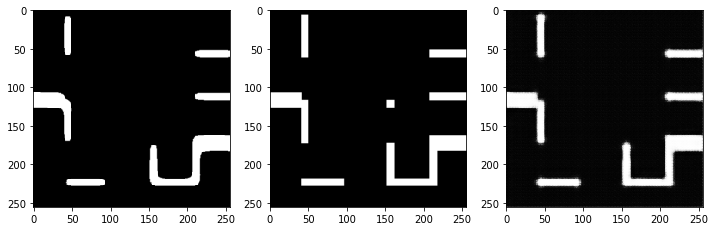

Epoch [2 / 100] time: 51.29 (sec) average reconstruction error: 533963.141949
Epoch [3 / 100] time: 52.17 (sec) average reconstruction error: 425230.907177
Epoch [4 / 100] time: 52.11 (sec) average reconstruction error: 386430.657508
Epoch [5 / 100] time: 52.27 (sec) average reconstruction error: 365648.125099
Epoch [6 / 100] time: 53.15 (sec) average reconstruction error: 353139.846796
Validation error: 359247.398295


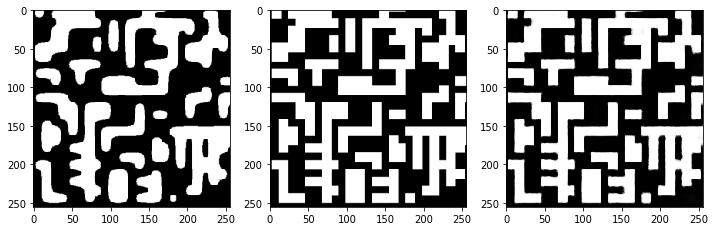

Epoch [7 / 100] time: 53.38 (sec) average reconstruction error: 345157.605535
Epoch [8 / 100] time: 52.68 (sec) average reconstruction error: 336366.194584
Epoch [9 / 100] time: 52.32 (sec) average reconstruction error: 329974.325576
Epoch [10 / 100] time: 52.73 (sec) average reconstruction error: 326047.680614
Epoch [11 / 100] time: 51.75 (sec) average reconstruction error: 320647.247319
Validation error: 344352.197159


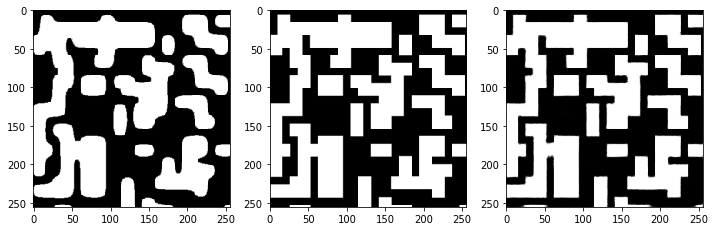

Epoch [12 / 100] time: 64.40 (sec) average reconstruction error: 314833.554688
Epoch [13 / 100] time: 54.37 (sec) average reconstruction error: 311697.599974
Epoch [14 / 100] time: 51.46 (sec) average reconstruction error: 308415.786745
Epoch [15 / 100] time: 53.42 (sec) average reconstruction error: 306033.830244
Epoch [16 / 100] time: 52.56 (sec) average reconstruction error: 302024.940877
Validation error: 347137.012500


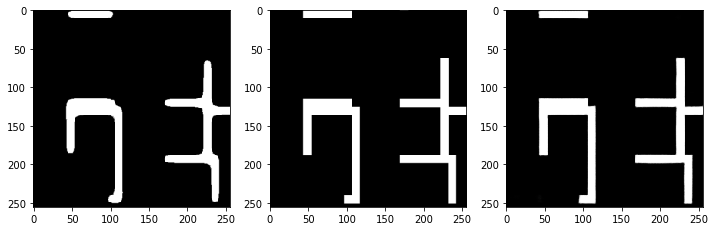

Epoch [17 / 100] time: 52.49 (sec) average reconstruction error: 299911.094909
Epoch [18 / 100] time: 52.53 (sec) average reconstruction error: 298411.580740
Epoch [19 / 100] time: 53.09 (sec) average reconstruction error: 296585.321835
Epoch [20 / 100] time: 52.12 (sec) average reconstruction error: 295033.955508
Epoch [21 / 100] time: 51.67 (sec) average reconstruction error: 293789.863050
Validation error: 341805.882386


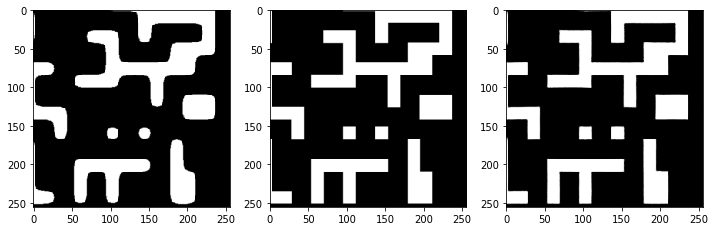

Epoch [22 / 100] time: 51.19 (sec) average reconstruction error: 291977.682932
Epoch [23 / 100] time: 52.05 (sec) average reconstruction error: 291132.140757
Epoch [24 / 100] time: 51.97 (sec) average reconstruction error: 290208.430085
Epoch [25 / 100] time: 51.62 (sec) average reconstruction error: 288768.770789
Epoch [26 / 100] time: 52.89 (sec) average reconstruction error: 287629.583355
Validation error: 344497.873295


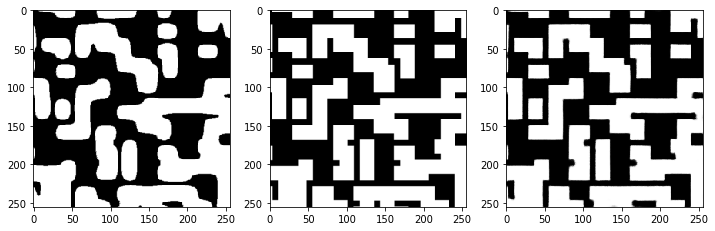

Epoch [27 / 100] time: 54.24 (sec) average reconstruction error: 286641.065943
Epoch [28 / 100] time: 53.13 (sec) average reconstruction error: 286292.960275
Epoch [29 / 100] time: 52.96 (sec) average reconstruction error: 285192.450477
Epoch [30 / 100] time: 53.75 (sec) average reconstruction error: 284882.673663
Epoch [31 / 100] time: 53.32 (sec) average reconstruction error: 284199.288136
Validation error: 345363.506818


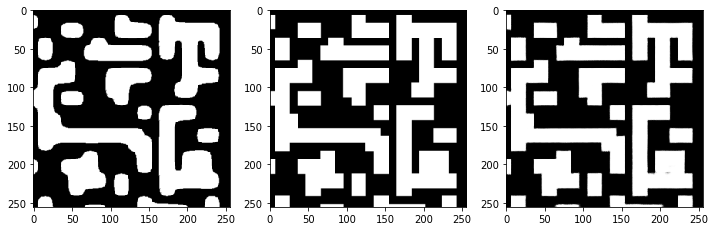

Epoch [32 / 100] time: 53.47 (sec) average reconstruction error: 283686.408236
Epoch [33 / 100] time: 53.09 (sec) average reconstruction error: 283097.990930
Epoch [34 / 100] time: 51.53 (sec) average reconstruction error: 282754.557899
Epoch [35 / 100] time: 51.16 (sec) average reconstruction error: 281968.566803
Epoch [36 / 100] time: 51.09 (sec) average reconstruction error: 280667.065479
Validation error: 347106.255114


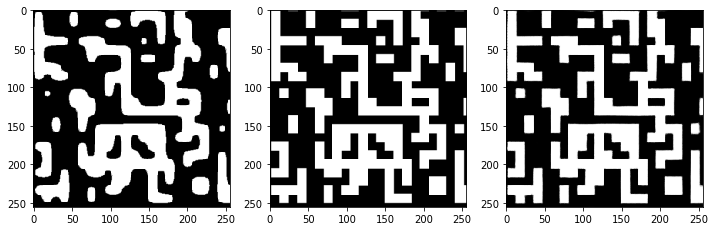

Epoch [37 / 100] time: 50.92 (sec) average reconstruction error: 280184.499934
Epoch [38 / 100] time: 50.93 (sec) average reconstruction error: 280342.067300
Epoch [39 / 100] time: 51.13 (sec) average reconstruction error: 280304.368512
Epoch [40 / 100] time: 51.03 (sec) average reconstruction error: 279802.562566
Epoch [41 / 100] time: 50.83 (sec) average reconstruction error: 278592.314420
Validation error: 345887.246591


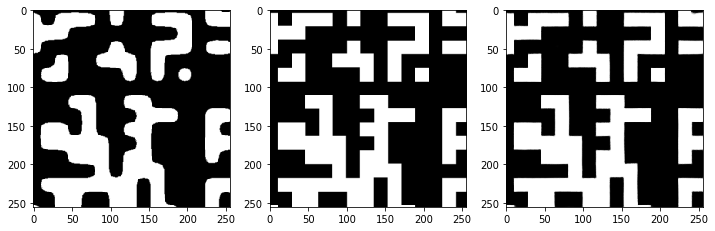

Epoch [42 / 100] time: 50.63 (sec) average reconstruction error: 278540.029264
Epoch [43 / 100] time: 51.10 (sec) average reconstruction error: 278087.026582
Epoch [44 / 100] time: 51.20 (sec) average reconstruction error: 277070.940711
Epoch [45 / 100] time: 50.96 (sec) average reconstruction error: 277144.357918
Epoch [46 / 100] time: 50.94 (sec) average reconstruction error: 276723.006157
Validation error: 350269.776136


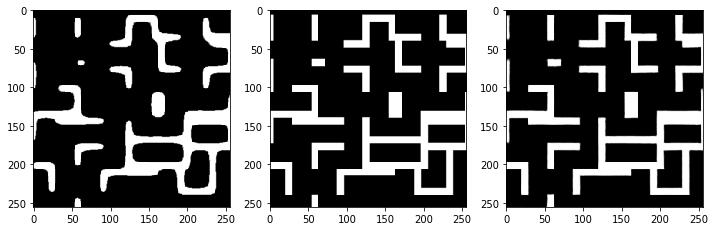

Epoch [47 / 100] time: 51.07 (sec) average reconstruction error: 276344.248577
Epoch [48 / 100] time: 51.12 (sec) average reconstruction error: 276391.675914
Epoch [49 / 100] time: 51.03 (sec) average reconstruction error: 276068.087990
Epoch [50 / 100] time: 51.27 (sec) average reconstruction error: 275684.514168
Epoch [51 / 100] time: 51.25 (sec) average reconstruction error: 275130.109805
Validation error: 350180.861364


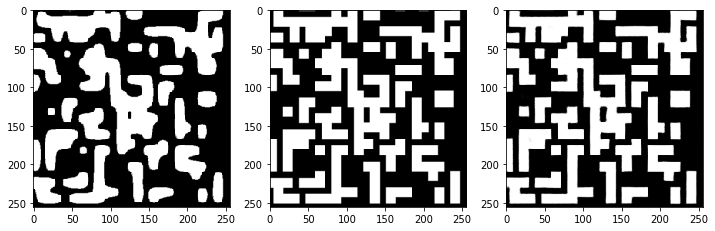

Epoch [52 / 100] time: 51.09 (sec) average reconstruction error: 274705.150556
Epoch [53 / 100] time: 51.17 (sec) average reconstruction error: 274203.789592
Epoch [54 / 100] time: 50.99 (sec) average reconstruction error: 274096.593618
Epoch [55 / 100] time: 50.95 (sec) average reconstruction error: 273923.287738
Epoch [56 / 100] time: 51.14 (sec) average reconstruction error: 273409.667240
Validation error: 357266.952841


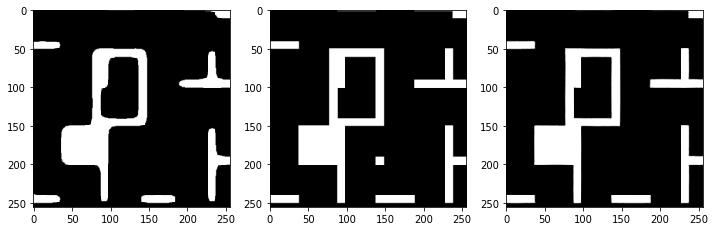

Epoch [57 / 100] time: 50.97 (sec) average reconstruction error: 273550.617717
Epoch [58 / 100] time: 51.10 (sec) average reconstruction error: 273077.567267
Epoch [59 / 100] time: 51.34 (sec) average reconstruction error: 272405.831899
Epoch [60 / 100] time: 51.23 (sec) average reconstruction error: 272367.922007
Epoch [61 / 100] time: 51.87 (sec) average reconstruction error: 272123.766486
Validation error: 353138.121023


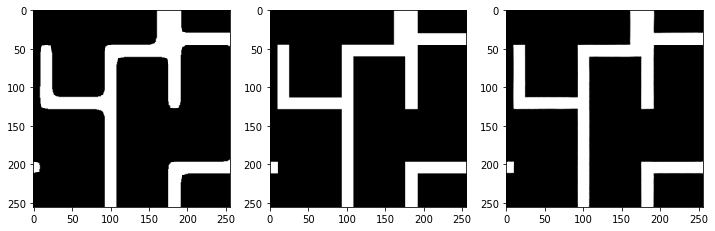

Epoch [62 / 100] time: 61.56 (sec) average reconstruction error: 272173.604376
Epoch [63 / 100] time: 60.40 (sec) average reconstruction error: 272164.482654
Epoch [64 / 100] time: 50.61 (sec) average reconstruction error: 271771.817995
Epoch [65 / 100] time: 50.76 (sec) average reconstruction error: 271851.599907
Epoch [66 / 100] time: 51.18 (sec) average reconstruction error: 271048.255793
Validation error: 359180.586364


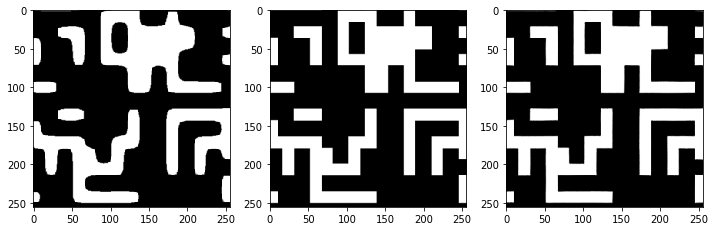

Epoch [67 / 100] time: 51.00 (sec) average reconstruction error: 271094.125066
Epoch [68 / 100] time: 50.98 (sec) average reconstruction error: 270337.900622
Epoch [69 / 100] time: 50.97 (sec) average reconstruction error: 270233.508177
Epoch [70 / 100] time: 51.13 (sec) average reconstruction error: 269730.913334
Epoch [71 / 100] time: 50.87 (sec) average reconstruction error: 269704.681773
Validation error: 360526.069886


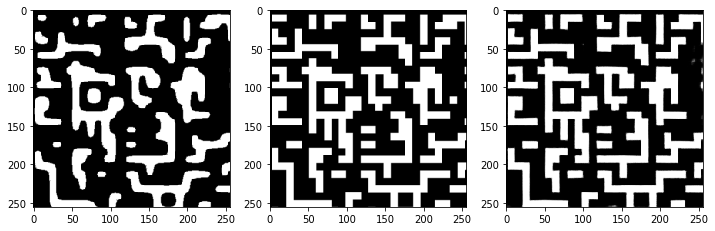

Epoch [72 / 100] time: 51.86 (sec) average reconstruction error: 269855.367717
Epoch [73 / 100] time: 51.42 (sec) average reconstruction error: 269163.499868
Epoch [74 / 100] time: 50.81 (sec) average reconstruction error: 269380.519068
Epoch [75 / 100] time: 51.06 (sec) average reconstruction error: 269043.145226
Epoch [76 / 100] time: 50.73 (sec) average reconstruction error: 269216.469180
Validation error: 359425.077273


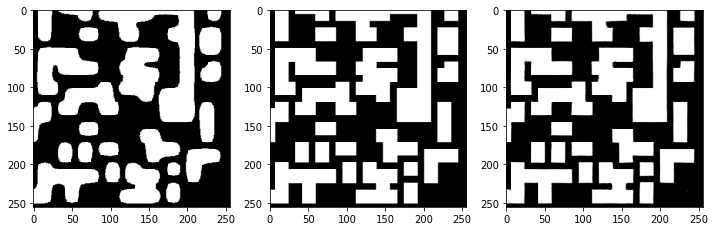

Epoch [77 / 100] time: 51.18 (sec) average reconstruction error: 269336.240234
Epoch [78 / 100] time: 50.92 (sec) average reconstruction error: 268644.798199
Epoch [79 / 100] time: 51.34 (sec) average reconstruction error: 268078.559653
Epoch [80 / 100] time: 53.84 (sec) average reconstruction error: 268088.069551
Epoch [81 / 100] time: 52.37 (sec) average reconstruction error: 268012.200543
Validation error: 362261.200000


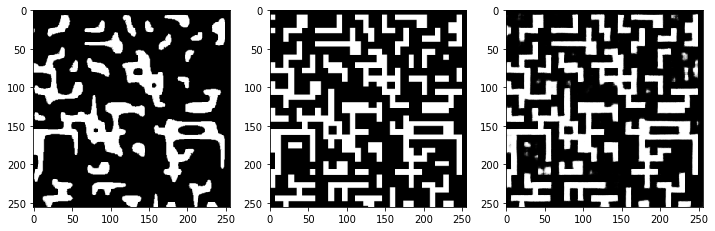

Epoch [82 / 100] time: 53.35 (sec) average reconstruction error: 267800.656482
Epoch [83 / 100] time: 52.21 (sec) average reconstruction error: 268289.735103
Epoch [84 / 100] time: 52.56 (sec) average reconstruction error: 268093.450410
Epoch [85 / 100] time: 52.46 (sec) average reconstruction error: 267563.319121
Epoch [86 / 100] time: 52.33 (sec) average reconstruction error: 267139.375596
Validation error: 364269.874432


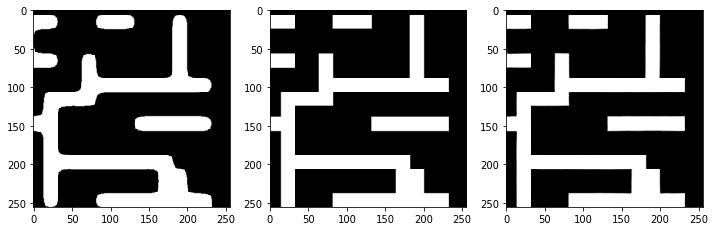

Epoch [87 / 100] time: 52.20 (sec) average reconstruction error: 266968.901284
Epoch [88 / 100] time: 51.58 (sec) average reconstruction error: 267061.643671
Epoch [89 / 100] time: 53.26 (sec) average reconstruction error: 267052.164592
Epoch [90 / 100] time: 54.12 (sec) average reconstruction error: 266607.021584
Epoch [91 / 100] time: 53.48 (sec) average reconstruction error: 266740.198027
Validation error: 367267.061364


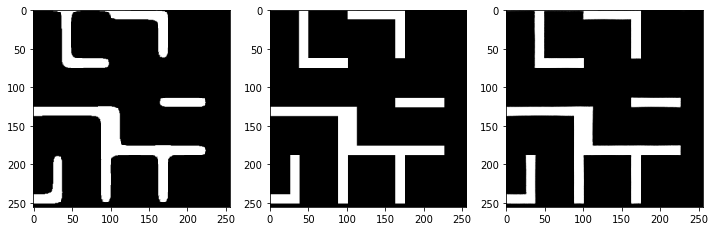

Epoch [92 / 100] time: 52.24 (sec) average reconstruction error: 266467.055548
Epoch [93 / 100] time: 52.86 (sec) average reconstruction error: 266020.112288
Epoch [94 / 100] time: 52.77 (sec) average reconstruction error: 265787.647378
Epoch [95 / 100] time: 51.84 (sec) average reconstruction error: 265864.987553
Epoch [96 / 100] time: 50.98 (sec) average reconstruction error: 265670.743048
Validation error: 365602.629545


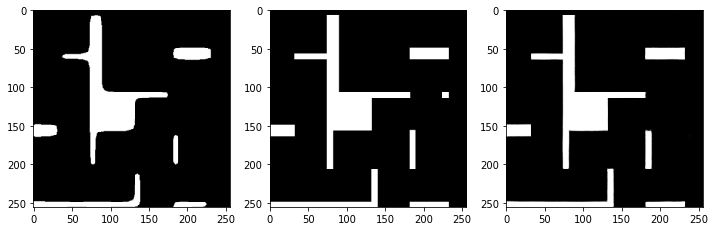

Epoch [97 / 100] time: 50.86 (sec) average reconstruction error: 265523.095339
Epoch [98 / 100] time: 50.95 (sec) average reconstruction error: 265692.078224
Epoch [99 / 100] time: 50.83 (sec) average reconstruction error: 265112.870564
Epoch [100 / 100] time: 50.85 (sec) average reconstruction error: 264963.913864


In [8]:
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
unet.train()

train_loss_avg = []
test_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    start_time = time.time()

    for image_batch, out_image_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        out_image_batch = out_image_batch.to(device)

        # unet reconstruction
        recon_image_batch = unet(image_batch)
        
        # reconstruction error
        loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                        out_image_batch.view(-1, image_size**2), reduction='sum')

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
          
    train_loss_avg[-1] /= num_batches
    end_time = time.time()
    print('Epoch [%d / %d] time: %.2f (sec) average reconstruction error: %f' % (epoch+1, num_epochs, end_time-start_time, train_loss_avg[-1]))
      
    if epoch % 5 == 0:
        test_loss = []
        for image_batch, out_image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            out_image_batch = out_image_batch.to(device)
            recon_image_batch = unet(image_batch)
            loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                          out_image_batch.view(-1, image_size**2), reduction='sum')
            test_loss.append(loss.item())
        
        test_loss_avg.append(np.mean(test_loss))
        print('Validation error: %f' % (test_loss_avg[-1]))
        
        fig, ax = plt.subplots(1,3, figsize=(12,5))
        ax[0].imshow(image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[1].imshow(out_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[2].imshow(recon_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        plt.show()
        
        if not os.path.isdir('./Unet_checkpoints'):
            os.makedirs('./Unet_checkpoints')
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss_avg,
                    'val_loss': test_loss_avg
                    }, './Unet_checkpoints/Unet_epoch_{}.pth'.format(epoch))

#         model = TheModelClass(*args, **kwargs)
#         optimizer = TheOptimizerClass(*args, **kwargs)

#         checkpoint = torch.load(PATH)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']

#         model.eval()
#         # - or -
#         model.train()

Plot Training Curve
--------------------

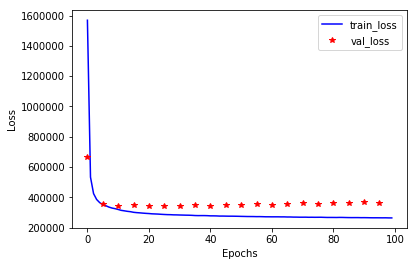

In [10]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'b', label='train_loss')
plt.plot(range(0,100,5), test_loss_avg, 'r*', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained VAE
-----------------------------

In [0]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

Evaluate on the Test Set
-------------------------

In [0]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807126


Visualize Reconstructions
--------------------------

Original images


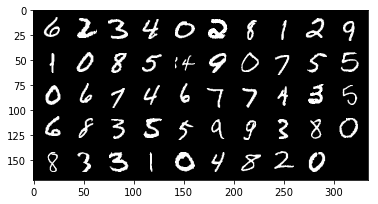

VAE reconstruction:


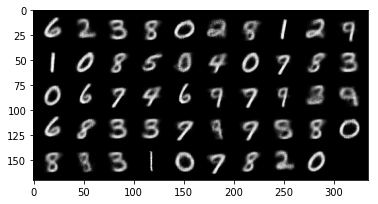

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

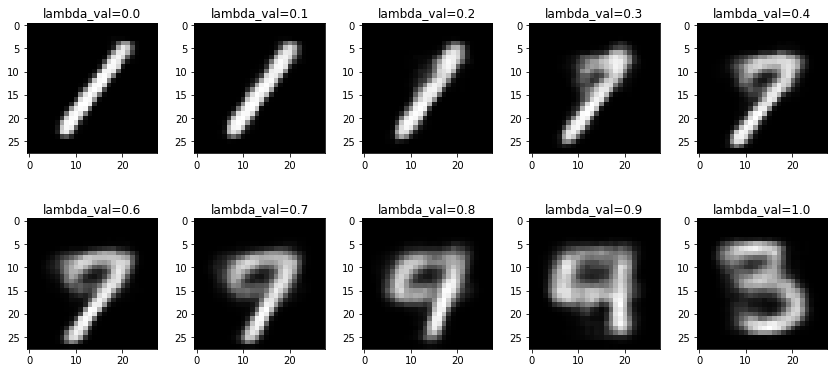

In [0]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

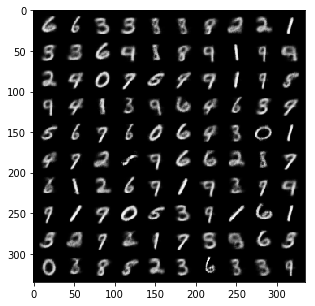

In [0]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

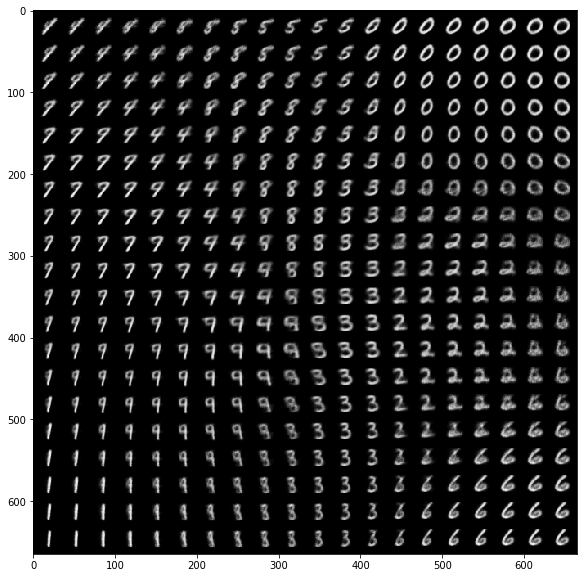

In [0]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()